<a href="https://colab.research.google.com/github/notakshitgoyal/neural_network_classification/blob/main/neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Make some Data

In [119]:
import sklearn

In [120]:
from sklearn.datasets import make_circles
#make 1000 samples
n_samples = 1000
#create circles
X,y = make_circles(n_samples,noise = 0.03,random_state= 42)

In [121]:
print(f"First 5 samples of X:{X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X:[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [122]:
#make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y
                       })
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


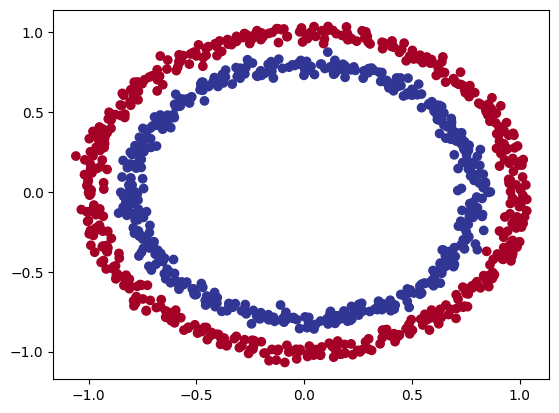

In [123]:
#visulaize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c = y,
            cmap=plt.cm.RdYlBu)

#check input and output shapes

In [124]:
X.shape,y.shape

((1000, 2), (1000,))

#turn data into tensors and create train and test splits

In [125]:
#turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [126]:
#split data into traing and test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

## building a model
1. Device agonistic code
2. construct a model (nn.Module)
3.define loss and optimizer
4.training and test loop

In [127]:
import torch
from torch import nn
#device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#constructing a model
1. Subclasses nn.Module
2. create 2 nn.Linear() layers that are capable of handling the shape of handling the shapes of our model
3. forward pass
4. initiate a instance for our model

In [128]:
class Circle_v0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features= 2,out_features= 5)
    self.layer_2 = nn.Linear(in_features = 5,out_features = 1)

  def forward(self,x):
    return self.layer2(self.layer1(x))


In [129]:
#instantiate an instance of our model
model_0 = Circle_v0().to(device)
model_0

Circle_v0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [130]:
#lets replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features= 2,out_features=5),
    nn.Linear(in_features= 5,out_features = 1)
).to(device)

In [131]:
#setup loss function and
import torch
import torch.optim as optim
import torch.nn as nn
loss_fn = nn.BCEWithLogitsLoss() #has sigmoid inbuilt
optimizer = optim.SGD(params=model_0.parameters(), lr=0.1)

In [132]:
#calculate accuracy
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [133]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0740],
        [ 0.2768],
        [ 0.0814],
        [-0.0209],
        [-0.0444]], device='cuda:0', grad_fn=<SliceBackward0>)

In [134]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4815],
        [0.5688],
        [0.5203],
        [0.4948],
        [0.4889]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [135]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 1., 1., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [136]:
y_test[:5]

tensor([0., 1., 1., 1., 1.])

#training model

In [137]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
#epochs
epochs = 100
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)
for epoch in range(epochs):
  model_0.train()
  #forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  #calculate the loss
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)
  #optimize zero grad
  optimizer.zero_grad()
  #backpropagation
  loss.backward()
  #optimizer step
  optimizer.step()
  #testing
  model_0.eval()
  with torch.inference_mode():
    #forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    #cal the loss
    test_loss= loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred = test_pred)
  #print out whats happening
  if epoch%10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69792, Accuracy: 52.50% | Test loss: 0.69456, Test acc: 55.00%
Epoch: 10 | Loss: 0.69586, Accuracy: 51.38% | Test loss: 0.69320, Test acc: 53.50%
Epoch: 20 | Loss: 0.69484, Accuracy: 50.38% | Test loss: 0.69272, Test acc: 53.50%
Epoch: 30 | Loss: 0.69427, Accuracy: 50.75% | Test loss: 0.69259, Test acc: 52.50%
Epoch: 40 | Loss: 0.69391, Accuracy: 50.25% | Test loss: 0.69260, Test acc: 51.00%
Epoch: 50 | Loss: 0.69368, Accuracy: 50.12% | Test loss: 0.69268, Test acc: 52.00%
Epoch: 60 | Loss: 0.69352, Accuracy: 49.62% | Test loss: 0.69278, Test acc: 52.00%
Epoch: 70 | Loss: 0.69340, Accuracy: 50.12% | Test loss: 0.69288, Test acc: 52.50%
Epoch: 80 | Loss: 0.69332, Accuracy: 49.88% | Test loss: 0.69299, Test acc: 52.00%
Epoch: 90 | Loss: 0.69326, Accuracy: 49.88% | Test loss: 0.69309, Test acc: 50.50%


In [138]:
#visualize
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists,skipping download")
else:
  print("Downloading function")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions,plot_decision_boundary

helper_functions.py already exists,skipping download


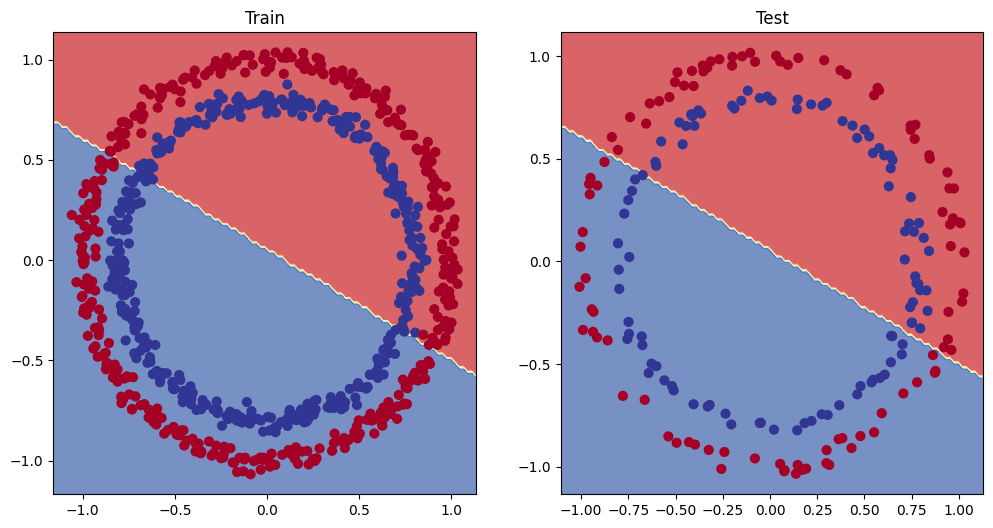

In [139]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

#improving a model(from models perspective)
* Add more layers
* Add more hidden layers
* Fit for longer
* changing the activation functions
* change the learning rate
* change the loss functions


In [140]:
class circleV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features= 2,out_features= 10)
    self.layer_2 = nn.Linear(in_features = 10,out_features = 10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))
model_1 = circleV1().to(device)
model_1

circleV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [141]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params= model_1.parameters(),lr = 0.1)
epochs = 1000
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)
for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true= y_train,
                    y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true= y_test,y_pred= test_pred)
    if epoch %100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69341, Accuracy: 52.00% | Test loss: 0.69477, Test acc: 46.50%
Epoch: 100 | Loss: 0.69310, Accuracy: 50.38% | Test loss: 0.69388, Test acc: 48.50%
Epoch: 200 | Loss: 0.69308, Accuracy: 50.25% | Test loss: 0.69375, Test acc: 48.50%
Epoch: 300 | Loss: 0.69308, Accuracy: 50.75% | Test loss: 0.69372, Test acc: 49.00%
Epoch: 400 | Loss: 0.69308, Accuracy: 50.38% | Test loss: 0.69372, Test acc: 49.50%
Epoch: 500 | Loss: 0.69308, Accuracy: 50.62% | Test loss: 0.69372, Test acc: 49.50%
Epoch: 600 | Loss: 0.69308, Accuracy: 50.50% | Test loss: 0.69372, Test acc: 49.50%
Epoch: 700 | Loss: 0.69308, Accuracy: 50.38% | Test loss: 0.69372, Test acc: 49.50%
Epoch: 800 | Loss: 0.69308, Accuracy: 50.38% | Test loss: 0.69372, Test acc: 49.50%
Epoch: 900 | Loss: 0.69308, Accuracy: 50.38% | Test loss: 0.69372, Test acc: 49.50%


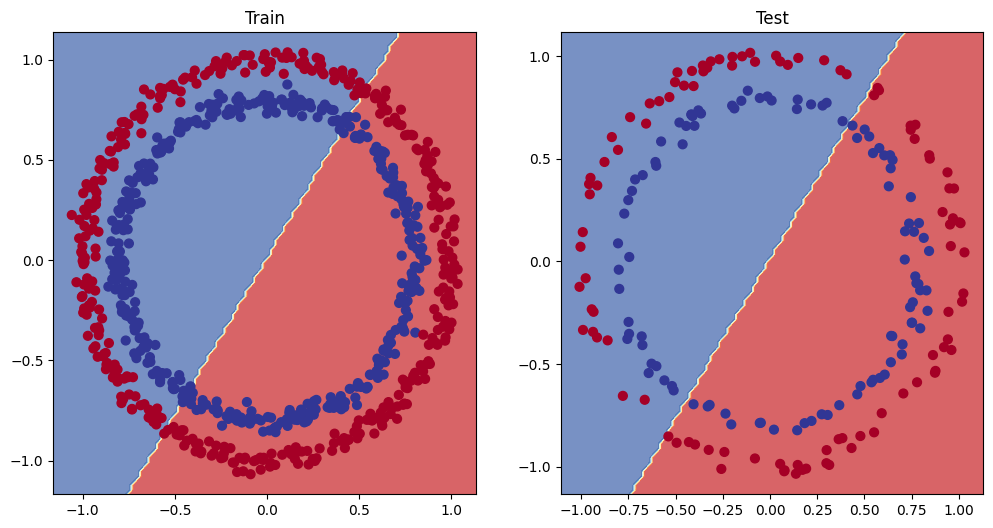

In [142]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

#creating some linear data

In [143]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [144]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


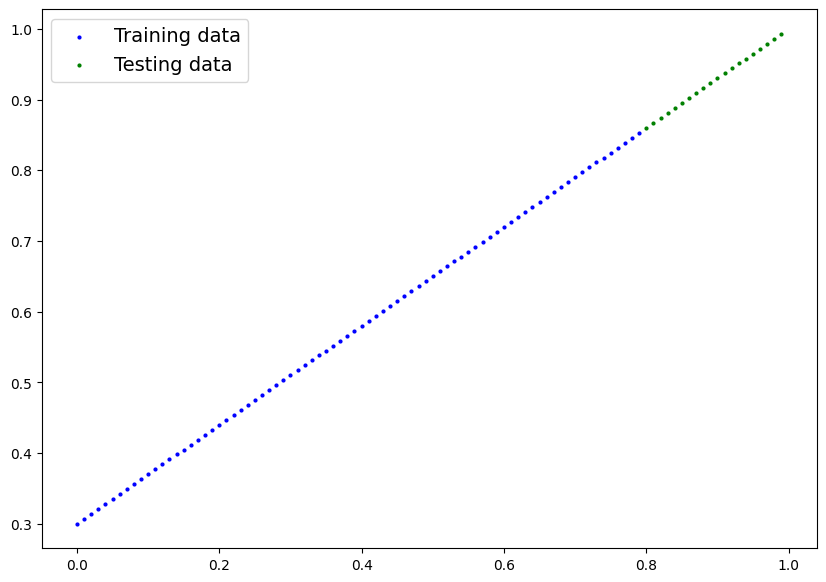

In [145]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [146]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2


Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [147]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [148]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.57896, Test loss: 0.47265
Epoch: 100 | Train loss: 0.05652, Test loss: 0.17491
Epoch: 200 | Train loss: 0.05272, Test loss: 0.15038
Epoch: 300 | Train loss: 0.05733, Test loss: 0.14733
Epoch: 400 | Train loss: 0.05780, Test loss: 0.14758
Epoch: 500 | Train loss: 0.04943, Test loss: 0.12419
Epoch: 600 | Train loss: 0.05284, Test loss: 0.14350
Epoch: 700 | Train loss: 0.07244, Test loss: 0.12574
Epoch: 800 | Train loss: 0.04493, Test loss: 0.11135
Epoch: 900 | Train loss: 0.05377, Test loss: 0.13252


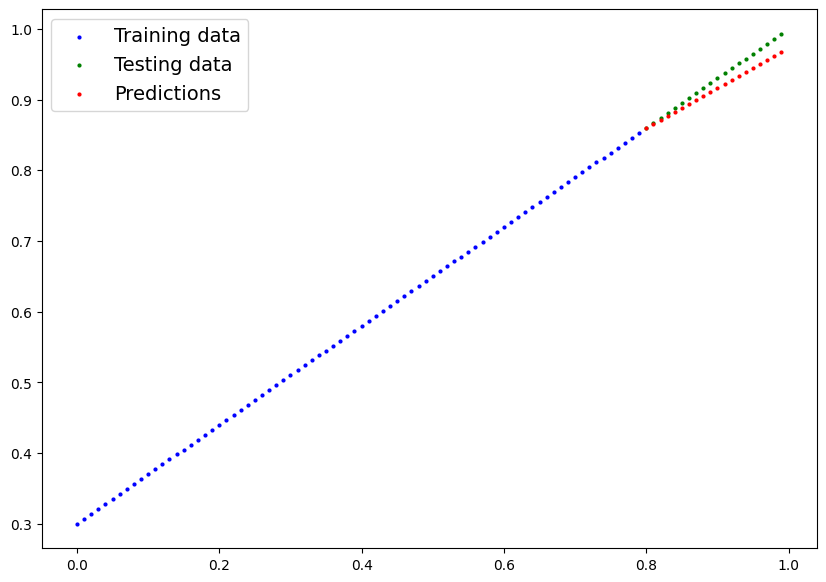

In [149]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

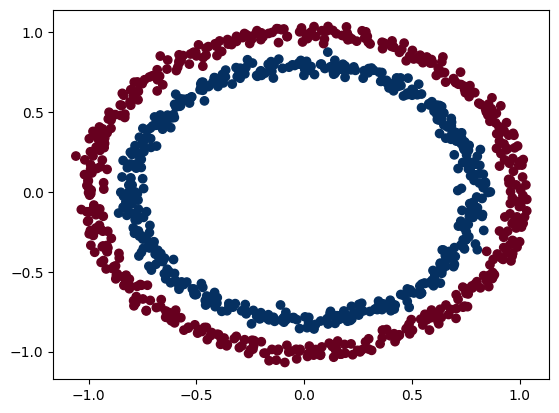

In [150]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [151]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

#building a model with non Linear

In [152]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [153]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [154]:
# Fit the model
torch.manual_seed(42)
epochs = 20000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1100 | Loss: 0.

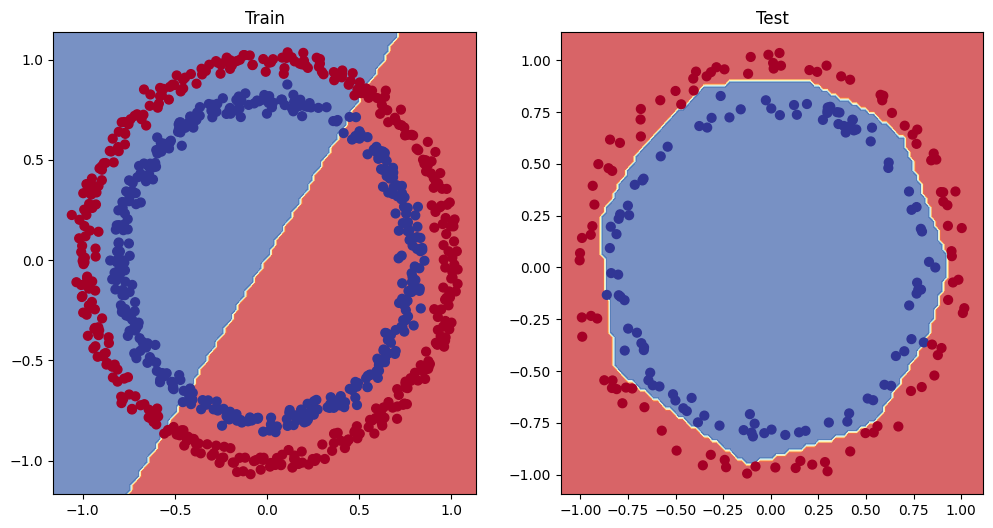

In [155]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity